# Formula 1 Statistics

# 0. Introduction


Formula 1 is the most global motorsport. One of the things that seperates F1 from every other sport is that there is no even playing field. Teams set out to build the fastest car possible within the rules (and bending the rules when able), which generally mean that the team with the most money builds the fastest car. Take for example, mercedes. Mercedes have dominated the sport since the last rules overhaul in 2014 and sell engines to other teams. The most striking highlight of this is the face that williams (currently one of the slowest teams on the grid) and mercedes (the most dominate team) use the same engines. The difference comes from how much more money Mercedes is able to throw at aerodynamic development. Also mention the example of George Russell almost winning in the Mercedes when he was borrowed from Williams. 

This makes any meaningful discussion of the quality between drivers incredibly difficult. Entire blogs and research papers from the statistics community have been dedicated disconnecting driver performance from car performance([f1 metrics blog](https://f1metrics.wordpress.com/), Find some actual research papers in math that I have encountered). 

In this write-up, I don't expect to definitevly answer that question. However, I would like to play around with the stats a little, and see if I can come up with some ways of my own to approach this question. 

I will evaluate a few key metrics
- distribution of lap times over a race and the "spread of spreads" of lap times over a season
- teammate head-to-head


Add somewhere: 
There are lots of tables in the database and lots of questions to ask, so I may periodically add sections with new questions to ask

- highlight some key findings
In this notebook, we explore the F1 dataset on [kaggle](https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020) using SQL.  

In [1]:
# basics
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Sql stuff
from psycopg2 import connect, extensions, sql
#from IPython.display import clear_output

# other
from datetime import datetime, time, date
from collections import defaultdict

# Load login info for postgres. 

with open("postgres_login_info.txt") as f: 
    login_info = f.read()
mpl.rcParams['figure.max_open_warning'] = 50

First, we will define a function to query the database. 

In [2]:
def query(text):
    """Run a query on the Formula_1_statistics database using the text input
    Parameters
    ---------
    text: SQL code to run
    
    Returns
    ---------
    df: DataFrame containing the result of the submitted query
    
    """
    with connect(login_info) as conn, conn.cursor() as cur:  
        autocommit = extensions.ISOLATION_LEVEL_AUTOCOMMIT
        conn.set_isolation_level(autocommit)
        
        query = sql.SQL(text)
        cur.execute(query)
        return pd.DataFrame(cur.fetchall(), columns = [desc[0] for desc in cur.description])

For plotting, define a few dictionaries for team colors and abreviations. At a future update I would like to make this into a seperate table with team name, color, an year to accommodate livery changes through the years. 

In [3]:
colors = defaultdict(lambda: '#FFFFFF', {
                     'Mercedes'      : '#00D2BE', 
                     'Ferrari'       : '#C00000', 
                     'Red Bull'      : '#0600EF', 
                     'Renault'       : '#FFF500', 
                     'Haas F1 Team'  : '#787878', 
                     'Racing Point'  : '#F596C8', 
                     'Force India'   : '#F596C8', 
                     'AlphaTauri'    : '#C8C8C8',
                     'Toro Rosso'    : '#469BFF',
                     'McLaren'       : '#FF8700', 
                     'Alfa Romeo'    : '#960000',
                     'Sauber'        : '#960000',
                     'Williams'      : '#0082FA', 
                     'Lotus F1'      : '#FFB800',
                     'Manor Marussia': '#6E0000'
                    })

team_abbrev = defaultdict(lambda: 'NA', {
                     'Mercedes'      : 'Merc', 
                     'Ferrari'       : 'Fer', 
                     'Red Bull'      : 'RB', 
                     'Renault'       : 'Ren', 
                     'Haas F1 Team'  : 'Has', 
                     'Racing Point'  : 'RP', 
                     'Force India'   : 'FI', 
                     'AlphaTauri'    : 'AT', 
                     'Toro Rosso'    : 'TR', 
                     'McLaren'       : 'McL', 
                     'Alfa Romeo'    : 'AR', 
                     'Sauber'        : 'Sau', 
                     'Williams'      : 'Wil',
                     'Lotus F1'      : 'Lot', 
                     'Manor Marussia': 'MM'
                    })

# 1. Lap distributions

## 1.1 Queries

Write a query that will get the lap times for one driver over the course of 1 race. These laps may be filtered by a multiple of the average lap time to remove safety car periods and pit stops. 

In [4]:
def get_lap_distribution(firstname=None, lastname=None, driverref=None, race=None, year=None, cutoff=1.2, 
                         filter_laps=False):
    """Query the database to get the lap time distribution for 1 driver over the course of 1 race. 
    
    Parameters 
    ---------
    firstname: string
        driver's first name
    lastname: string
        driver's last name
    driverref: string
        driver reference- can substitute for first name and last name (e.g. pass driverref="HAM" instead of 
        firstname="Lewis", lastname="Hamilton")
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
    cutoff: float > 1
        will remove lap times longer than cutoff * average lap time
    filter_laps: boolean
        Currently unused. Whether or not to filter laps using cutoff. For now, use cutoff=10 to include all laps. 
    """
    
    
    text = f"""
    
    -- Get a list of lap times for the specific race
    WITH times AS (SELECT EXTRACT(MINUTES FROM lap_times.time)*60 +
                            EXTRACT(SECONDS FROM lap_times.time) AS lap_time, 
                        lap_times.lap, 
                        lap_times.position, 
                        lap_times.driverid, 
                        lap_times.raceid,
                        EXTRACT(YEAR FROM races.date) AS year
                 FROM lap_times 
                 JOIN races ON lap_times.raceid = races.raceid 
                 JOIN circuits ON races.circuitid = circuits.circuitid
                 WHERE ((races.name iLike '%{race}%') AND year = {year})
                 ),
   
   -- Get the pit stops. 
    pits AS (SELECT pit_stops.driverid, 
                    pit_stops.raceid, 
                    pit_stops.stop, 
                    pit_stops.lap AS pit_lap, 
                    pit_stops.time, 
                    pit_stops.duration
             FROM pit_stops
             JOIN races ON pit_stops.raceid = races.raceid
             JOIN drivers ON pit_stops.driverid = drivers.driverid
             WHERE(
                  (races.name iLike '%{race}%') 
                   AND year = {year}
                   AND ((drivers.forename iLike '%{firstname}%'
                       AND drivers.surname iLike '%{lastname}%') 
                        OR drivers.driverref iLike '%{driverref}%')
                  )
    ), 
    
    average_lap AS (SELECT AVG(times.lap_time) AS time FROM times) 
              
              
    SELECT lap_times.lap,
           CASE 
               WHEN (EXTRACT(MINUTES FROM lap_times.time)*60 + EXTRACT(SECONDS FROM lap_times.time) 
               > {cutoff} * (SELECT average_lap.time FROM average_lap)) THEN NULL 
               ELSE (EXTRACT(MINUTES FROM lap_times.time)*60 + EXTRACT(SECONDS FROM lap_times.time)) 
           END AS lap_time,
           CASE
               WHEN lap_times.lap IN (SELECT pits.pit_lap FROM pits) THEN TRUE
               ELSE FALSE
            END AS pit_lap, 
           lap_times.position,
           drivers.forename, 
           drivers.surname, 
           drivers.code, 
           races.name, 
           races.year, 
           status.status
           
    FROM lap_times
    
    JOIN drivers ON drivers.driverid = lap_times.driverid
    JOIN races ON races.raceid       = lap_times.raceid
    JOIN results ON results.raceid   = lap_times.raceid
    JOIN status ON results.statusid  = status.statusid
    
    WHERE(
        
        -- filter drivers
        ((drivers.forename iLike '%{firstname}%'
        AND drivers.surname iLike '%{lastname}%')
        OR drivers.driverref iLike '%{driverref}%')
        
        -- filter results
        AND results.driverid = (
                SELECT driverid
                FROM drivers
                WHERE ((drivers.forename iLike '%{firstname}%'
                        AND drivers.surname iLike '%{lastname}%')
                        OR drivers.driverref iLike '%{driverref}%')
                LIMIT 1
                )

        -- filter races
        AND races.name iLike '%{race}%' AND races.year = {year}
    ) 
    """
    
    
    return query(text)

def get_race_distribution(race, year, cutoff=1.2, skip_cut_laps=False, drop_first_lap=False, 
                         drop_pit=False, drop_out_lap=False):
    """Query a dataframe to get the lap times of every driver on the grid over the course of a race"""
    
    text = f"""

    SELECT drivers.forename AS firstname,
           drivers.surname AS lastname,
           drivers.code, 
           drivers.driverid, 
           drivers.driverref,
           results.positionorder,
           races.name AS race_name, 
           constructors.name AS team
           
    FROM drivers
    
    JOIN results ON results.driverid = drivers.driverid
    JOIN races ON races.raceid = results.raceid
    JOIN constructors ON constructors.constructorid = results.constructorid
    
    WHERE races.year = {year} AND races.name iLike '%{race}%'
    """
    
    drivers_df =  query(text);

    frames = [get_lap_distribution(driverref=ref, race=race, year=year, cutoff=cutoff) 
              for ref in drivers_df['driverref']];
    
    # replace none with Nan (this happened with Sainz in the 2019 Belgian grand prix- retired on first lap)
    
    lap_time_results = pd.concat(frames).sort_values(by="lap_time")
    lap_time_results['team'] = [drivers_df[drivers_df['code'] == i]['team'].values[0] for i in lap_time_results['code']]
    lap_time_results.fillna(value=np.nan, inplace=True)
    
    if drop_first_lap: 
        lap_time_results.drop(lap_time_results[lap_time_results['lap']==1].index, inplace=True)
        
    #if drop_out_lap:
    #    lap_time_results.drop(
    #        lap_time_results[(lap_time_results['lap'].isin(
    #            [lap_time_results['lap'][lap_time_results['pit_lap']==True]+1]))])
    #print(lap_time_results)
    
    if drop_pit: 
        for driver in lap_time_results['code'].unique(): 
            print(f"driver: {driver}")
            
            laps_to_drop = lap_time_results[(lap_time_results['pit_lap'] == True) &  
                                                   (lap_time_results['code'] == driver)]['lap'].values
            print(f"dropping: {laps_to_drop}")
            
            lap_time_results.drop(lap_time_results[(lap_time_results['pit_lap'] == True) &  
                                                   (lap_time_results['code'] == driver)].index, inplace=True)
     
    return lap_time_results.sort_values(by="position")

## TODO: make a plot of the deltas between teammates

## TODO: make a plot of the distribution of deltas (divided by average lap time) over all the races to directly compare teammates

Now get the lap times for every driver over the course of a race. 

## 1.2 Plots

## Make race traces for the given race

In [101]:
def get_race_trace(race=None, year=None, cutoff=10, measure="average", drop_first_lap=False, make_plot=True): 
    """Function to plot the race traces. """
    
    # TODO: re-adjust time vector for how deltas are calculated. Reference: https://www.kaggle.com/jtrotman/f1-race-traces-2020
    
    df = get_race_distribution(race=race, year=year, cutoff=cutoff, drop_first_lap=drop_first_lap)
    laps = df['lap'].sort_values().unique()
    
    if measure == "average": 
        time = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps])
    if measure == "cumulative average":
        time_0 = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps])
        time = time_0.cumsum(skipna=True)
    else: 
        time = pd.Series([np.median(df['lap_time'][df['lap'] == lap]) for lap in laps])
    
    
    if make_plot == True: 
        sns.set_style("darkgrid")
        fig, ax = plt.subplots(figsize=[10, 8])
    
    for team in df['team'].unique(): 
        drivers = df['code'][df['team'] == team].unique()
        labels = ["a", "b"]

        for i in range(len(drivers)): 
            
            if df['status'][(df['code'] == drivers[i])].values[0] != "Finished": 
                labels[i] = drivers[i] + " (" + df['status'][df['code'] == drivers[i]].values[0] + ")"
            else: 
                labels[i] = df['code'][df['code'] == drivers[i]].values[0]
        
        # calculate the deltas for each measure
            if (measure == "average") or (measure == "median"): 
                deltas = lambda driver: [(df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)]
                                          - time[lap - 1]).values[0]
                                         for lap in laps if 
                                         len(df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)]) > 0 ]

                
            elif measure == "cumulative average":
                deltas = lambda driver: pd.Series([df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)].values[0]
                                      for lap in laps if
                                      len(df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)]) > 0]
                                    ).cumsum(skipna=True) - time
        
        if make_plot == False: 
            continue
            
        if len(drivers) == 0: 
            continue
        plt.plot(deltas(drivers[0]), 
                 color=colors[df['team'][df['code'] == drivers[0]].values[0]], 
                 label=labels[0], 
                 linestyle='-',
                 linewidth=2)
        
        if len(drivers) == 1: 
            continue
        
        plt.plot(deltas(drivers[1]), 
                 color=colors[df['team'][df['code'] == drivers[1]].values[0]], 
                 label=labels[1], 
                 linestyle='--',
                 linewidth=2)
        
    if make_plot == True:
        ax.set_title(f"race traces for the {year} {df['name'].values[0]} using {measure} time")
        ax.set_xlabel("lap")
        ax.set_ylabel("delta (seconds)")
        ax.legend(bbox_to_anchor=(1,1),
                  loc='upper left',
                  ncol=1,  
                  fontsize=10)
    return df

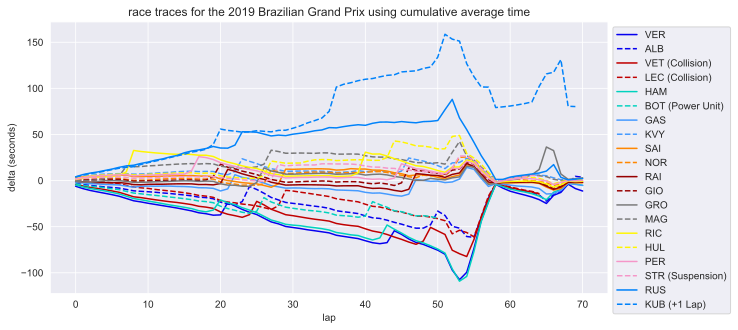

In [102]:
df, _ = plot_race_trace(race="Brazilian", year=2019, measure="cumulative average");

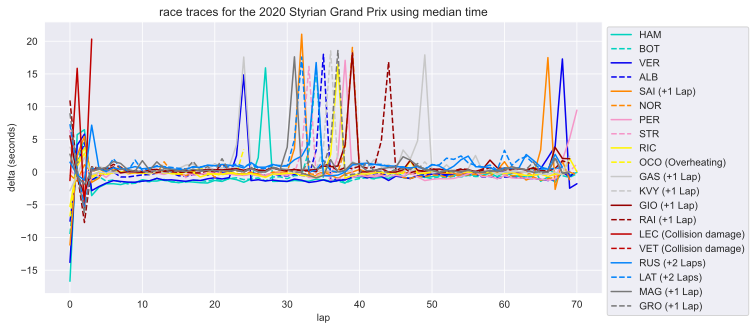

In [89]:
plot_race_trace(race="Styrian", year=2020, measure="median");

In [9]:
def plot_team_trace(race=None, year=None, cutoff=10, drop_first_lap=False): 
    
    ## TODO: format after adjusting above code
    
    df = get_race_distribution(race=race, year=year, cutoff=cutoff, drop_first_lap=drop_first_lap)
    fig, ax = plt.subplots(nrows=len(df['team'].unique()), figsize=[10, 20])
    
    laps = df['lap'].sort_values().unique()
    avg_time = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps])
    
    for index, team in pd.Series(df['team'].unique()).items():
        for driver in df['code'][df['team']==team].unique():
            deltas = [ (df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)] - avg_time[lap - 1]).values[0]
                      for lap in laps if len(df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)]) > 0 ]
            ax[index].plot(deltas, color=colors[df['team'][df['code']==driver].values[0]])
        

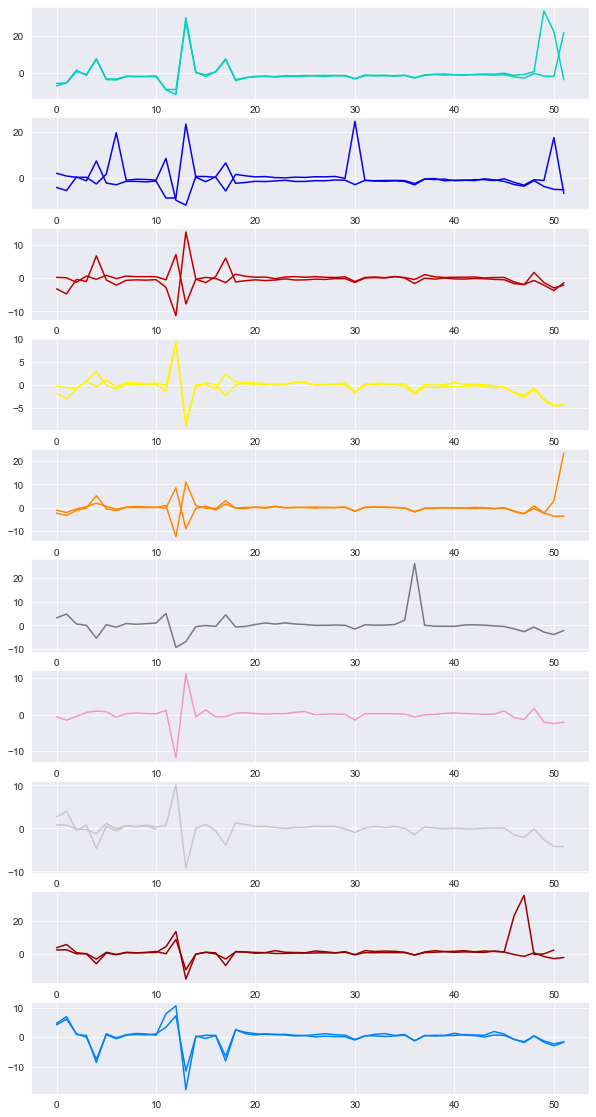

In [10]:
plot_team_trace(race="British", year=2020)

# 2. Consistency

# 2.1 Lap time distributions

In this section, we'll plot the distribution of lap times over the course of a race. 

One of the ways to measure the quality of a driver is by their consistency. And one of the ways to measure consistency is to study the distribution of lap times during a race. To do that, we can use the coefficient of variaiton ($\frac{\sigma}{\mu}$) which is a way to measure the variances of sample distirbutions with different means. 

In [11]:
def get_finishing_order(race, year):
    results_text = f"""
    SELECT results.positionorder, 
           drivers.code
    FROM results
    JOIN races ON races.raceid = results.raceid
    JOIN drivers ON drivers.driverid = results.driverid
    WHERE races.year = {year} AND races.name iLike '%{race}%' 
    
    ORDER BY results.positionorder
    """
    results_df = query(results_text); 
    return results_df

def plot_race_distribution(race, year, outliers=False, whis=1.5, cutoff=1.2, colors=colors, bw=1.2, 
                           drop_first_lap=True, drop_pit=True, drop_out_lap=True): 
    """Plot the distribution of lap times over the course of a race"""
    
    df = get_race_distribution(race=race, year=year, cutoff=cutoff, drop_first_lap=drop_first_lap, 
                              drop_pit=True, drop_out_lap=True);
 
    fastest_lap = df['lap_time'].min()
    slowest_lap = df['lap_time'].max()
    
    # get the finishing order
    finishing_order = get_finishing_order(race=race, year=year)['code'].to_numpy()
    
    sns.set_style("ticks")
    
    %config InlineBackend.figure_format = 'svg'
    
    # filter out the non-finishers
    accepted_statuses = ['Finished', '+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps']
    #df = df.drop(df[~df['status'].isin(accepted_statuses)].index)
    
    fig, ax = plt.subplots(figsize=[9, 4])
    
    # make plots
    sns.violinplot(ax=ax, 
                   data=df, 
                   y="lap_time", 
                   x="code", 
                   hue="team", 
                   palette=colors, 
                   order=finishing_order, 
                   showfliers=outliers,
                   dodge=False, 
                   #inner="stick",
                   bw=bw
                  )
    ax.legend(bbox_to_anchor=(1,1),
              loc='upper left',
              ncol=1,  
              fontsize=12)

    ax.set_xlabel("driver", fontsize=12)
    ax.set_ylabel("lap time (seconds)", fontsize=12),
    ax.set_ylim([(fastest_lap-0.5), fastest_lap*(cutoff)+2])
    ax.tick_params(labelsize=10)
    ax.autoscale(enable=True)
    ax.set_title(f"Lap time distribution for the {year} {df['name'].values[0]}\n", fontsize=15)
    return ax, df#, df_predrop

driver: LEC
dropping: [13 36]
driver: HAM
dropping: [34]
driver: BOT
dropping: [12 37]
driver: VET
dropping: [14 35 38]
driver: KVY
dropping: [12]
driver: HUL
dropping: [32]
driver: GIO
dropping: [40 16]
driver: GAS
dropping: [9]
driver: VER
dropping: [11 32]
driver: SAI
dropping: [24  4]
driver: RAI
dropping: [ 9 33]
driver: NOR
dropping: [10]
driver: MAG
dropping: [10 38]
driver: PER
dropping: [8]
driver: RIC
dropping: []
driver: ALB
dropping: [25]
driver: STR
dropping: []
driver: GRO
dropping: []
driver: RUS
dropping: [26]
driver: KUB
dropping: [11]


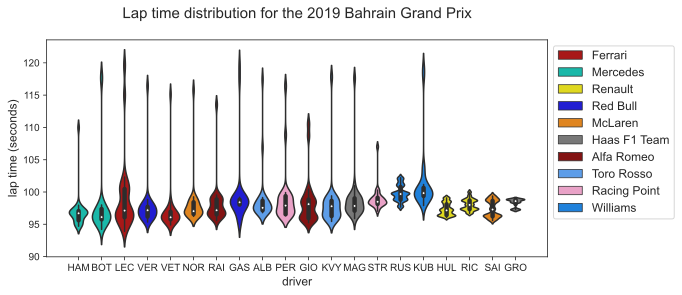

In [12]:
ax, df = plot_race_distribution(race="Bahrain", year=2019, cutoff=1.2, bw=0.2);

Make a plot of all the races in a season for debugging. 

In [13]:
def plot_all_races(year=None, cutoff=1.2, outliers=True, bw=0.2):
    text = f"""
    SELECT name
    FROM races
    WHERE year = {year}
    ORDER BY round
    """

    df = query(text)
    return_df = pd.DataFrame()
    for race in df['name']: 
        try: 
            #print(race)
            _, df2 = plot_race_distribution(race, year=year, cutoff=cutoff, outliers=outliers, bw=bw)
            #print(df2)
            #return df2
            return_df = return_df.append(df2)
        except Exception as e: 
            print(f"no data for {race}")
            print(str(e))
            return get_race_distribution(race, year=year, cutoff=cutoff)
    return return_df

driver: BOT
dropping: [23]
driver: HAM
dropping: [15]
driver: VER
dropping: [25]
driver: LEC
dropping: [28]
driver: GAS
dropping: [37]
driver: KVY
dropping: [26]
driver: STR
dropping: []
driver: VET
dropping: [14]
driver: MAG
dropping: [14]
driver: ALB
dropping: [14]
driver: RAI
dropping: [12]
driver: HUL
dropping: [13]
driver: GRO
dropping: []
driver: GIO
dropping: []
driver: PER
dropping: []
driver: NOR
dropping: []
driver: RUS
dropping: [42]
driver: KUB
dropping: [44 28]
driver: RIC
dropping: []
driver: SAI
dropping: []
driver: LEC
dropping: [13 36]
driver: HAM
dropping: [34]
driver: BOT
dropping: [12 37]
driver: VET
dropping: [14 35 38]
driver: KVY
dropping: [12]
driver: HUL
dropping: [32]
driver: GIO
dropping: [40 16]
driver: GAS
dropping: [39  9]
driver: VER
dropping: [11 32]
driver: SAI
dropping: [40 24  4]
driver: RAI
dropping: [ 9 33]
driver: NOR
dropping: [10]
driver: MAG
dropping: [10]
driver: PER
dropping: [33]
driver: RIC
dropping: []
driver: ALB
dropping: []
driver: STR
d

driver: HAM
dropping: [42 21]
driver: LEC
dropping: [ 3 46 25]
driver: MAG
dropping: [47 17]
driver: BOT
dropping: [36 17]
driver: VET
dropping: [31 16]
driver: GIO
dropping: [49 18]
driver: PER
dropping: [41 19]
driver: ALB
dropping: [34 15]
driver: RAI
dropping: []
driver: KVY
dropping: [27]
driver: RIC
dropping: [29]
driver: SAI
dropping: [26]
driver: NOR
dropping: [4]
driver: STR
dropping: []
driver: HUL
dropping: []
driver: GRO
dropping: [16]
driver: GAS
dropping: []
driver: RUS
dropping: [25]
driver: KUB
dropping: [22 33]
driver: VER
dropping: []
driver: LEC
dropping: [43 15]
driver: ALB
dropping: [44 14]
driver: VET
dropping: [37]
driver: HAM
dropping: [23]
driver: BOT
dropping: []
driver: GAS
dropping: [9]
driver: KVY
dropping: [44 10]
driver: RAI
dropping: [52 15]
driver: RIC
dropping: [50]
driver: SAI
dropping: []
driver: VER
dropping: [5]
driver: PER
dropping: [20]
driver: KUB
dropping: [60 21]
driver: HUL
dropping: [18]
driver: STR
dropping: []
driver: GIO
dropping: []
driv

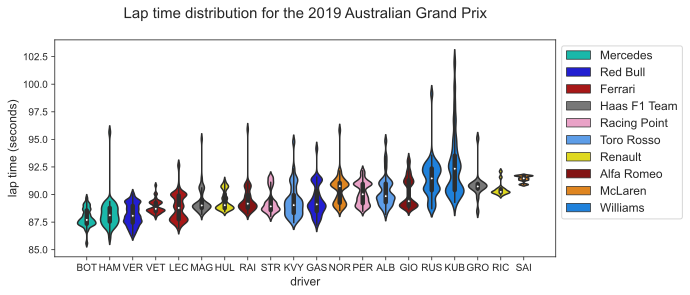

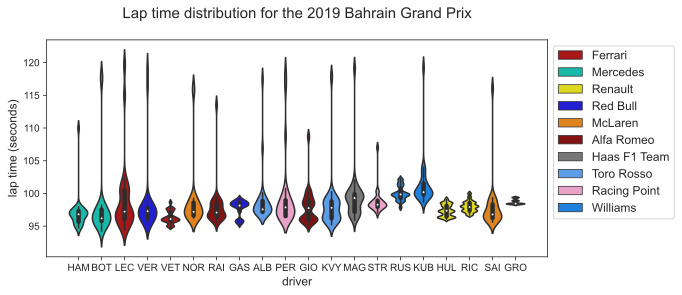

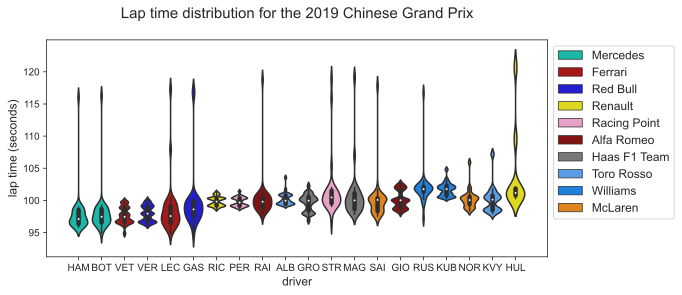

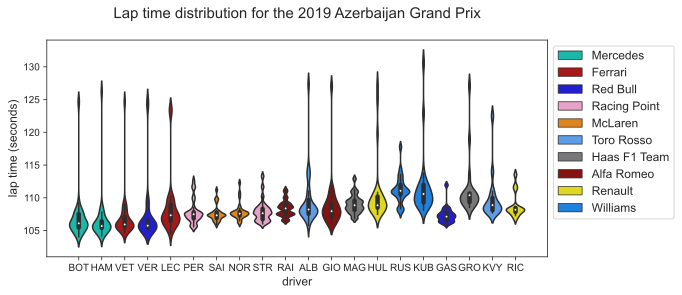

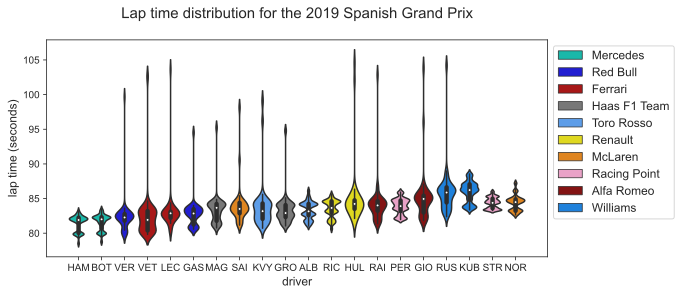

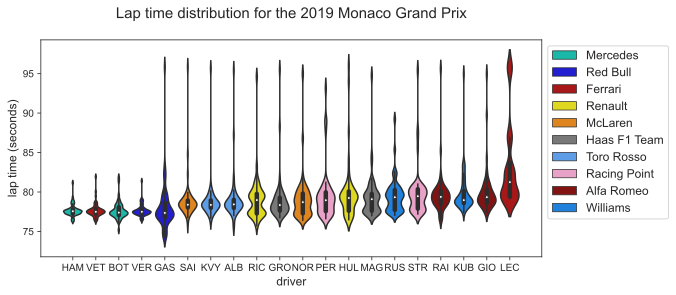

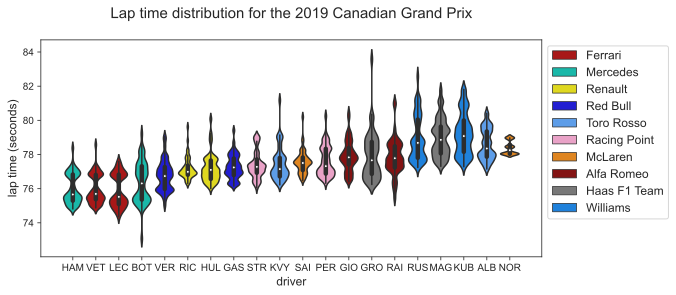

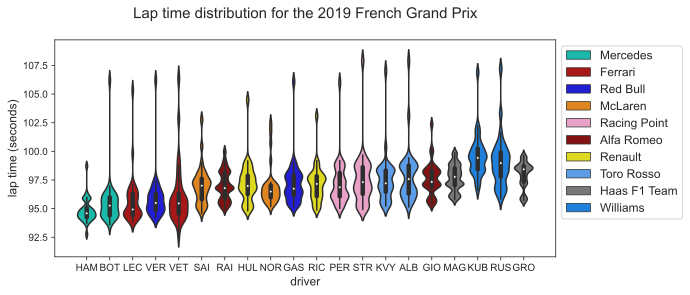

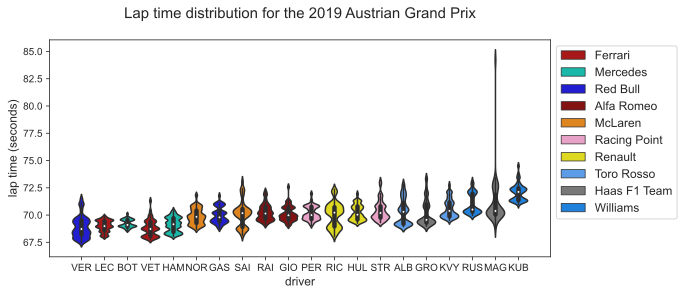

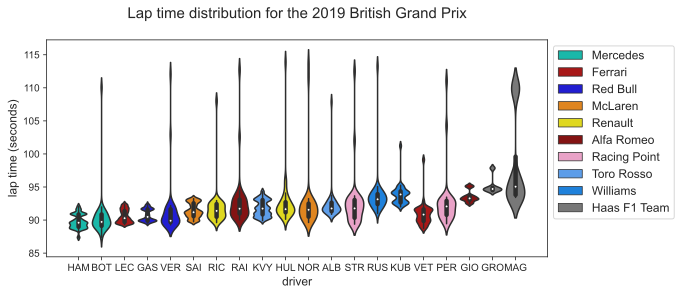

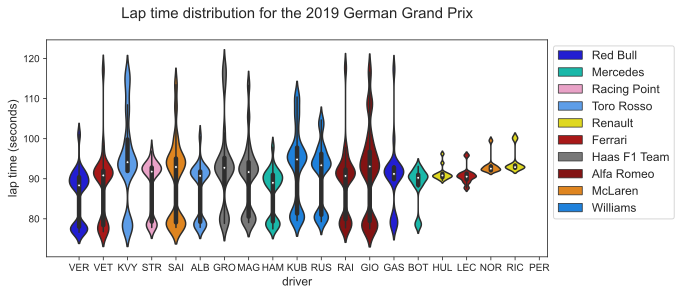

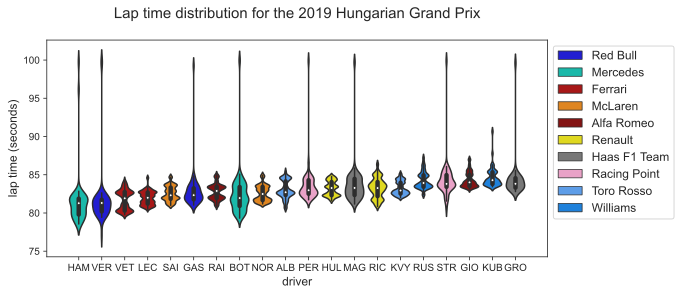

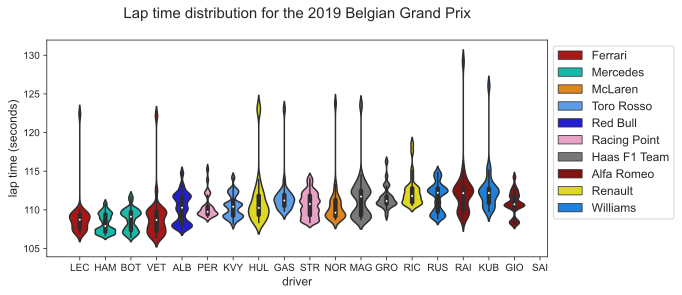

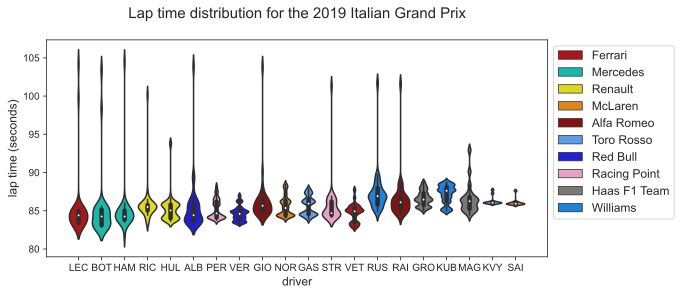

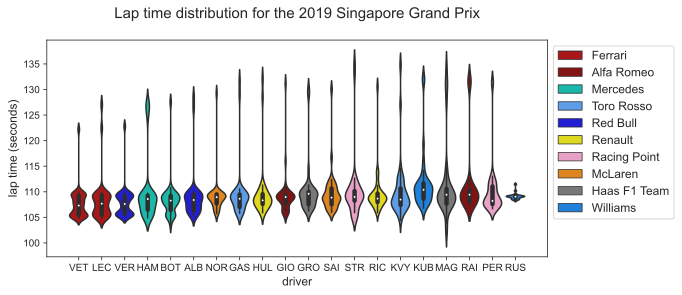

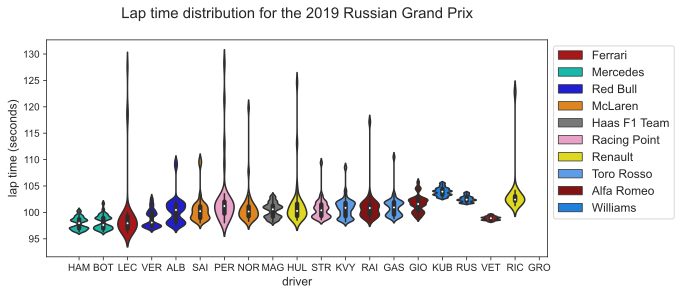

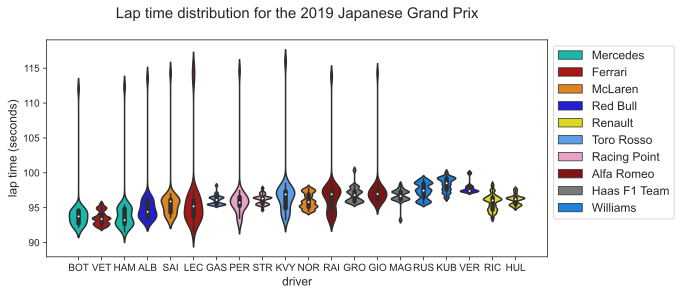

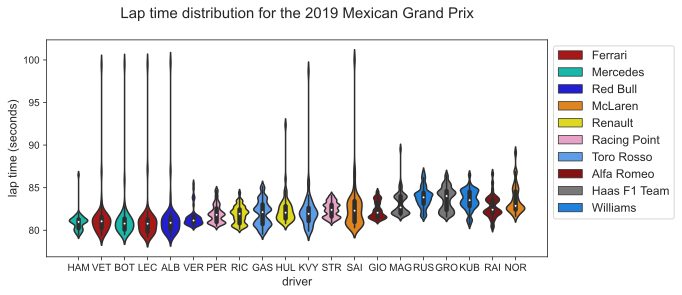

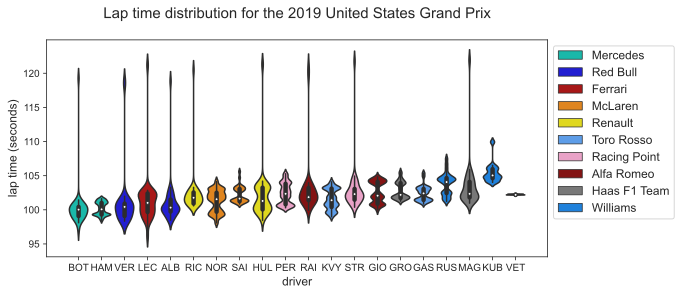

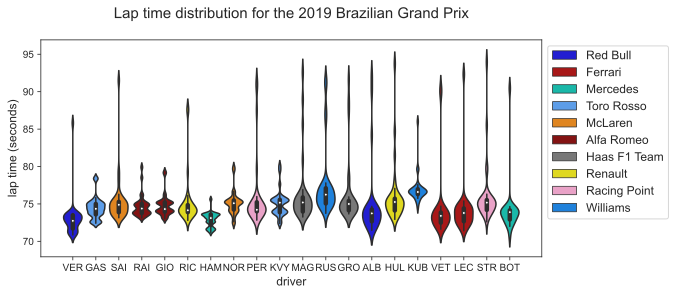

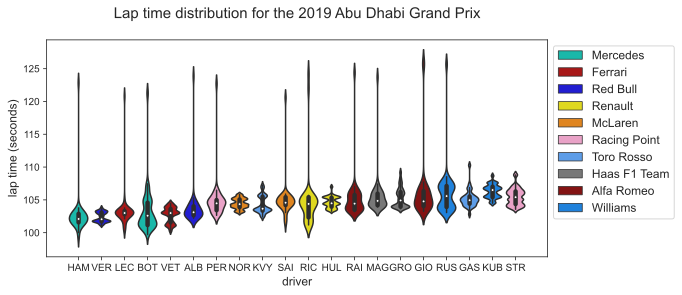

In [14]:
df4 = plot_all_races(2019, cutoff=1.2, outliers=True)

TODO: 
- Look into the anomalous results in several races (Japanese Grand Prix, Belgian Grand Prix, & German Grand Prix)- update: these errors were due to dropping retirements, not sure why. 

# 2.2 Coefficients of variation over the course of a season

## Consistency over the course of a season

While drivers may make mistakes during the race, one way to judge the overall consistency of a driver is to calculate the variation in lap times over the course of a season. To remove the effects of lap times changing by circuit, we calculate the coefficient of variation, $c_v = \frac{\sigma}{\mu}$ ($\sigma$ = standard deviation, $\mu$ = average) for each race and investigate the distribution of these variations. 

In [15]:
def get_season_finishing_order(year): 
    
    results_text = f"""
    SELECT driver_standings.position, driver_standings.points, drivers.code, drivers.forename, drivers.surname
    FROM driver_standings
    JOIN drivers ON drivers.driverid = driver_standings.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = {year} AND races.round = (SELECT MAX(races.round) FROM races WHERE races.year = {year})
    """
    results_df = query(results_text).sort_values(by='points', ascending=False);
    return results_df

In [16]:
def team_switches(df): 
    for driver in df['code']: 
        if len(df['team'][df['code'] == driver].unique())>1: 
            for team in df['team'][df['code'] == driver].unique(): 
                df.loc[(df['code'] == driver) & (df['team'] == team), 'code'] = f"{driver}\n({team_abbrev[team]})"
    return df

def calc_variations(year=2020, plot=True, team_abbrev=team_abbrev, bw=.15): 
    """Plot the distrubution of lap time variations for each driver over the course of a season.
    
    Parameters
    -------
    year: selected year (2020 default)
    plot: if true, plots are automatically generated, if false, only calculated data frames are returned
    team_abbrev: dictionary of team abbreviations. In the case of mid season driver changes (e.g. Pierre Gasly and 
        Alex Albon's swap in 2019), the lap time distribution is segregated between each team and the team abbreviation
        is appended to the driver code for better discernment. 
    
    Returns
    -------
    df: merged DataFrame containing the race variation info and season results
    season_results: DataFrame containing the standings at the end of the selected season
    race_data: DataFrame with the coefficient of variation for each race for each driver
    Axes: array with the 2 axis handles for each plot (only returned if plot is True)
    """
    
    races_query = f"""
    SELECT name
    FROM races
    WHERE year = {year}
    ORDER BY round
    """
    
    drivers_query = f"""
    SELECT DISTINCT drivers.code
    FROM drivers
    JOIN driver_standings ON driver_standings.driverid = drivers.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = {year}
    """
    # set font sizes for axes
    LARGE_FONT = 18
    MED_FONT   = 12
    SMALL_FONT = 9
    
    # Get all the races in a single season.
    races = query(races_query)['name'].to_numpy() 
    
    # get the drivers for a given season
    drivers = query(drivers_query)['code'].to_numpy()             
    
    # initialize a dataframe for the coefficients of variation in every race
    race_data = pd.DataFrame(columns = ['race', 'driver', 'team',  'coef_of_var'])
    
    # get the final season standings
    season_results = get_season_finishing_order(year)
    
    # loop through each race and calculate the coefficient of variation for each driver
    for race in races: 
        #print(race)
        try:
            race_dist = get_race_distribution(race, year) 
        except Exception as e: 
            print(f"no data for {race}")
            print(str(e))
        
        num_laps = max(race_dist['lap'].values)
        
        # loop through each driver
        for driver in drivers: 
            laps = race_dist['lap_time'][race_dist['code']==driver].values
            
            # filter drivers that completed less than 75% of the race distance
            if len(laps) < 0.75 * num_laps: 
                continue
            
            #print(laps)
            
            # get average, standard deviation, and team
            avg  = np.nanmean(laps)
            sd   = np.nanstd(laps)
            team = race_dist['team'][race_dist['code'] == driver].values[0]
              
            # append to dataframe
            race_data = race_data.append({'race'       : race,
                                          'code'       : driver, 
                                          'team'       : team, 
                                          'coef_of_var': sd/avg}, 
                                           ignore_index=True)
            #print("===================")
    # merge the race data and season results to properly order the drivers
    df = pd.merge(race_data, season_results, left_on='code', right_on='code')

    # handle mid-season driver switches
    # add team abbreviation to driver code if they drove for multiple teams in the same season
    #df_before_multi_team = df
    df = team_switches(df)

            
    # return the dataframes if we're not plotting anything
    if plot == False: 
         return df, season_results, race_data
        
     # make box plots, order by drivers standings
    fig, ax = plt.subplots(nrows=2, figsize=[8,8])
    
    plt.subplots_adjust(hspace=0.5)
    sns.violinplot(data=df, 
                   x='code',
                   y='coef_of_var', 
                   ax=ax[0], 
                   hue='team', 
                   palette=colors, 
                   dodge=False,
                   bw=bw, 
                   order=df.sort_values(by='points', ascending=False)['code'].unique()
                   )

    ax[0].set_title(f"\nCoefficient of variation distributions for the {year} season, ordered by driver standings\n", 
                    fontsize=LARGE_FONT)
    

    # order by average coefficient of variation
    order_var = pd.DataFrame(columns = ['code', 'avg_coef_of_var'])
    
    for driver in df['code'].unique(): 
        avg_var = np.nanmean(df['coef_of_var'][df['driver']==driver])
        order_var = order_var.append({'code': driver, 'avg_coef_of_var': avg_var}, ignore_index=True)

    sns.violinplot(data=df, 
                x=df['code'], 
                y='coef_of_var', 
                ax=ax[1], 
                hue='team', 
                palette=colors, 
                dodge=False,
                bw=bw,
                order=order_var.sort_values(by='avg_coef_of_var')['code'].to_numpy()
               )

    ax[1].set_title(f"\nCoefficient of variation distributions for the {year} season, ordered by lowest average variation\n",
                    fontsize = LARGE_FONT)
    
    # format axes
    for i in [0,1]:
        ax[i].set_xlabel("driver\n",                 fontsize=MED_FONT)
        ax[i].set_ylabel("coefficient of variation", fontsize=MED_FONT)
        ax[i].tick_params(axis='x',                  labelsize=SMALL_FONT)
        ax[i].tick_params(axis='y',                  labelsize=SMALL_FONT)
        ax[i].legend(bbox_to_anchor=(1,1), loc = 'upper left', ncol=1, fontsize=MED_FONT)
    return df, season_results, race_data, [ax[0], ax[1]]

<ipython-input-16-757ea1708b11>:127: RuntimeWarning: Mean of empty slice
  avg_var = np.nanmean(df['coef_of_var'][df['driver']==driver])


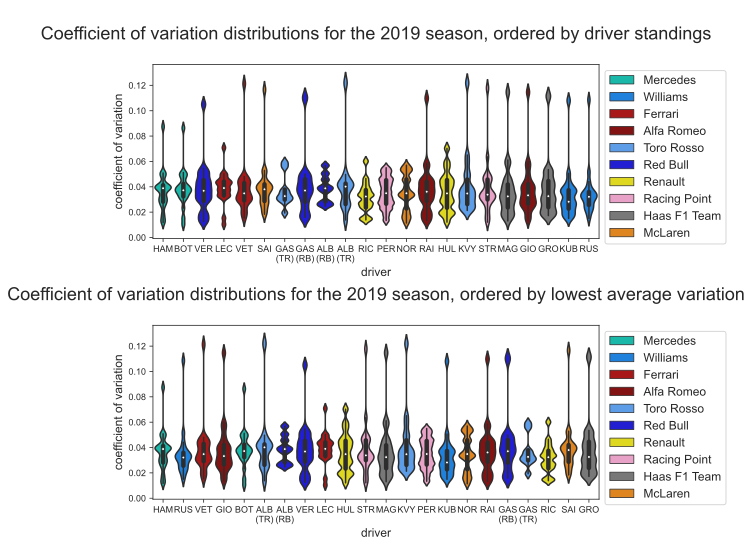

In [17]:
df, season_results, race_data, axes = calc_variations(year=2019, plot=True)

(add discussion here once all bugs are fixed)

# 3. Finishing position vs. grid position

Another way to measure the relative quality between drivers is their average start vs. average finishing position. 

List of metrics to look at: 
a
- distribution of starting positions
- distribution of finishing positions
- distribution of positions gained / lost over a race

Write a query to get the race results

In [18]:
df.head()

race  driver      team  coef_of_var code  position points  \
0  Australian Grand Prix     NaN  Mercedes     0.030904  HAM         1    413   
1     Bahrain Grand Prix     NaN  Mercedes     0.039809  HAM         1    413   
2     Chinese Grand Prix     NaN  Mercedes     0.041234  HAM         1    413   
3  Azerbaijan Grand Prix     NaN  Mercedes     0.038813  HAM         1    413   
4     Spanish Grand Prix     NaN  Mercedes     0.039093  HAM         1    413   

  forename   surname  
0    Lewis  Hamilton  
1    Lewis  Hamilton  
2    Lewis  Hamilton  
3    Lewis  Hamilton  
4    Lewis  Hamilton

In [19]:
def get_results(race=None, year=None): 
    text = f"""
    SELECT drivers.forename, 
           drivers.surname,
           drivers.code, 
           constructors.name AS team, 
           races.name,
           results.grid, 
           results.position, 
           results.positiontext, 
           results.points, 
           results.laps, 
           results.fastestlap, 
           results.fastestlaptime, 
           status.status
            
    FROM RESULTS
    
    JOIN drivers ON results.driverid = drivers.driverid
    JOIN races ON results.raceid = races.raceid
    JOIN status ON results.statusid = status.statusid
    JOIN constructors ON constructors.constructorid = results.constructorid
    
    WHERE races.year = {year} AND races.name iLike '%{race}%'
    """
    return query(text)

def get_season_results(year=None): 
    text = f"""
    SELECT races.name
    FROM races
    WHERE races.year = {year}
    """
    
    races = query(text).to_numpy()
    df = pd.DataFrame()
    for race in races: 
        df = df.append(get_results(race=race[0], year=year))
    df = team_switches(df)
    return df

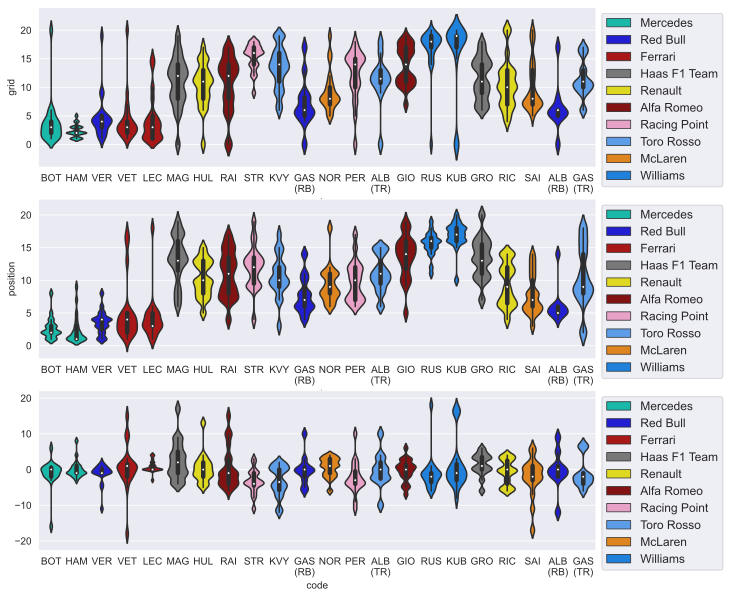

In [20]:
df = get_season_results(year=2019)
sns.set_style("darkgrid")
fig, ax = plt.subplots(nrows=3, figsize=[10, 10])



sns.violinplot(x=df['code'], 
               y=df['grid'], 
               ax=ax[0],
               dodge=False, 
               bw=.2,
              hue=df['team'], 
                palette=colors,)
sns.violinplot(x=df['code'], 
               y=df['position'], 
               ax=ax[1],
               dodge=False, 
               bw=.2,
              hue=df['team'], 
                palette=colors,)
sns.violinplot(x=df['code'], 
               y=df['position'] - df['grid'], 
               ax=ax[2],
               dodge=False, 
               bw=.2,
               hue=df['team'], 
               palette=colors,)
for i in range(3): 
    ax[i].legend(bbox_to_anchor=(1,1), loc = 'upper left', ncol=1, fontsize=12)

TODO: Fix legends, separate team changes

# 4. Retirements
Look at which driver had which kind of retirements

In [21]:
df.head()

forename     surname code      team                   name  grid  \
0   Valtteri      Bottas  BOT  Mercedes  Australian Grand Prix     2   
1      Lewis    Hamilton  HAM  Mercedes  Australian Grand Prix     1   
2        Max  Verstappen  VER  Red Bull  Australian Grand Prix     4   
3  Sebastian      Vettel  VET   Ferrari  Australian Grand Prix     3   
4    Charles     Leclerc  LEC   Ferrari  Australian Grand Prix     5   

   position positiontext points  laps  fastestlap   fastestlaptime    status  
0       1.0            1     26    58        57.0  00:01:25.580000  Finished  
1       2.0            2     18    58        57.0  00:01:26.057000  Finished  
2       3.0            3     15    58        57.0  00:01:26.256000  Finished  
3       4.0            4     12    58        16.0  00:01:27.954000  Finished  
4       5.0            5     10    58        58.0  00:01:26.926000  Finished

In [22]:
df['status'].unique()

array(['Finished', '+1 Lap', '+2 Laps', '+3 Laps', 'Wheel', 'Damage',
       'Engine', 'Out of fuel', 'Collision damage', 'Retired',
       'Collision', 'Power Unit', 'Transmission', 'Brakes', 'Suspension',
       'Spun off', 'Accident', 'Power loss', 'Exhaust', 'Water pressure',
       'Hydraulics', 'Disqualified', 'Overheating', 'Withdrew',
       'Oil leak'], dtype=object)

For each driver, plot histograms of their individual retirements

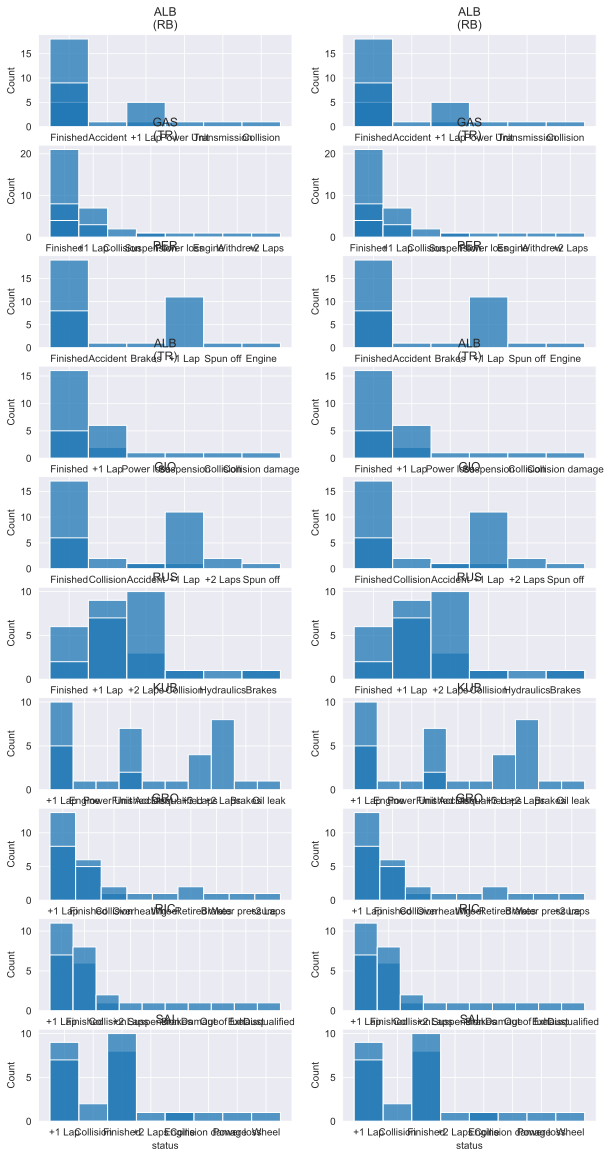

In [23]:
mechanical_dnf = ["Wheel", "Engine", "Out of Fuel", "Power Unit", "Transmission", "Brakes", "Suspension", "Power loss", 
                 "Exhaust", "Water pressure", "Hydraulics", "Overheating", "Oil leak"]

crash_dnf = ["Damage", "Collision damage", "Retired", "Collision", "Spun off", "Accident", "Disqualified", "Withdrew"]


fig, ax = plt.subplots(nrows=10, ncols=2, figsize=[10, 20])
drivers = pd.Series(df['code'].unique())

for i, driver in drivers.items(): 
    row = i%10
    for j in range(2): 
        #print(f"driver={driver}")
        col = j
        #print(f"row={row}; col={col}")
        sns.histplot(x='status', data = df[df['code']==driver], ax=ax[row][col])
        ax[row][col].set_title(driver)